In [52]:
import pandas as pd
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re


df = pd.read_csv('/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/csv_files/NY_Airbnb_original_df.csv')

# 전처리 1 - id int로 변경
df['id'] = df['id'].astype(int)

# booking_info
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['instant_bookable'] =  df['instant_bookable'].map({'f':0, 't':1})
df['is_long_term'] = (df['minimum_nights'] >= 28).astype(int)

# amenities_info
def parse_amenities(x):
    try:
        return [a.strip().strip('"').strip("'") for a in ast.literal_eval(x)]
    except:
        return []
    
df['amenities'] = df['amenities'].apply(parse_amenities)
df['amenities_cnt'] = df['amenities'].apply(len)

# host_info
# neighborhood_overview 결측치 많아서 유무대체 
df['neighborhood_overview_exists'] = df['neighborhood_overview'].notnull().astype(int)

# name 글자수기준 중앙값으로 그룹
df['name_length'] = df['name'].fillna('').astype(str).apply(len)
med_length = df['name_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
    
df['name_length_group'] = df['name_length'].apply(lambda x: name_length_group(x, med_length))

# description 글자수기준(결측치 405) 평균으로 그룹
df['description_length'] = df['description'].fillna('').astype(str).apply(len)
avg_length = df['description_length'].mean()

def name_length_group(length, avg):
    if length == 0:
        return 'empty'
    elif length > avg:
        return 'long'
    else:
        return 'short_or_avg'
    
df['description_length_group'] = df['description_length'].apply(lambda x: name_length_group(x, avg_length))

# host_about (결측치8917) 평균(243) 중앙값(81) 중앙값기준으로 그룹
df['host_about_length'] = df['host_about'].fillna('').astype(str).apply(len)
med_length = df['host_about_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
df['host_about_length_group'] = df['host_about_length'].apply(lambda x: name_length_group(x, med_length))


#host_identity_verified/host_has_profile_pic /host_is_superhost  
# True / Flase 1과 0으로 대체 (결측치 20/20/350 0으로 대체함)
df['host_identity_verified']=df['host_identity_verified'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_has_profile_pic']=df['host_has_profile_pic'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_is_superhost']=df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

# host_response_time 결측치는 중앙값으로 치환후 점수
response_time_score_map = { 
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_score'] = df['host_response_time'].map(response_time_score_map)

# 2. response_time_score 컬럼의 중앙값 계산
med_score_for_fillna = df['host_response_time_score'].median()

# 3. response_time_score 컬럼의 NaN을 계산된 중앙값으로 대체 
df['host_response_time_score'] = df['host_response_time_score'].fillna(med_score_for_fillna)

# host_response_time 칼럼에는 여전히 nan값 존재함
# response_time_score 칼럼만 중앙값대체 


# host_response_rate 컬럼 %제외하고 중앙값으로 대체
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate2 = df['host_response_rate'].median()
df['host_response_rate']= df['host_response_rate'].fillna(med_rate2)

# 4그룹으로 나눠 점수
conditions = [
    (df['host_response_rate'] <= 0.25),
    (df['host_response_rate'] > 0.25) & (df['host_response_rate'] <= 0.5),
    (df['host_response_rate'] > 0.5) & (df['host_response_rate'] <= 0.75),
    (df['host_response_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_response_rate_score'] = np.select(conditions, choices)


# host_acceptance_rate 칼럼도 %제외하고 중앙값으로 대체 
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate = df['host_acceptance_rate'].median()
df['host_acceptance_rate']= df['host_acceptance_rate'].fillna(med_rate)

conditions = [
    (df['host_acceptance_rate'] <= 0.25),
    (df['host_acceptance_rate'] > 0.25) & (df['host_acceptance_rate'] <= 0.5),
    (df['host_acceptance_rate'] > 0.5) & (df['host_acceptance_rate'] <= 0.75),
    (df['host_acceptance_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_acceptance_rate_score'] = np.select(conditions, choices)

# host_location 칼럼 
# host_loc 존재?
df['host_location_boolean'] = df['host_location'].notnull().astype(int)
# host_loc in NY?
df['host_location_ny'] = df['host_location'].str.contains('New York', na=False).astype(int)



# === rooms_info ===
# --- Personal preprocessing code ---
# Convert "beds" from float to int
# Replace missing or non-bed values with median (assumed 1)
df['beds'] = df['beds'].fillna(0).astype(int)
df['beds'] = df['beds'].replace(0, 1)

# Clean up "bathrooms", "bathrooms_text" column:
# - Replace invalid or missing values with median (assumed 1)
df['bathrooms'] = df['bathrooms'].fillna(0)

def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    if 'half' in s:
        return 0.5
    return np.nan

df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)
mask_mismatch = df['bathrooms_parsed'].notna() & (df['bathrooms'] != df['bathrooms_parsed'])
df.loc[mask_mismatch, 'bathrooms'] = df.loc[mask_mismatch, 'bathrooms_parsed']
df = df.drop(columns=['bathrooms_parsed'])

df['bathrooms_text'] = df['bathrooms_text'].fillna(0)

df['is_shared'] = df['bathrooms_text'] \
    .str.contains('shared', case=False, na=False)

df['is_private'] = ~df['is_shared']

w_private = 1.0   # 전용 욕실 가중치
w_shared  = 0.5   # 공용 욕실 가중치

df['bath_score_mul'] = (
    df['bathrooms'] * np.where(df['is_private'], w_private, w_shared)
)

df['bathrooms'] = df['bathrooms'].replace(0.00, 1)
df['bath_score_mul'] = df['bath_score_mul'].replace(0.00, 1)

# Clean up "room_type", "property_type" column:
def extract_structure(pt):
    pt_l = pt.strip().lower()
    if ' in ' in pt_l:
        return pt_l.split(' in ',1)[1].strip()
    if pt_l.startswith('entire '):
        return pt_l.replace('entire ','').strip()
    if pt_l.startswith('private room'):
        return pt_l.replace('private room','').strip()
    if pt_l.startswith('shared room'):
        return pt_l.replace('shared room','').strip()
    return pt_l

rt_cats = set(df['room_type'].str.strip().str.lower())
df['room_structure_type'] = df['property_type'].apply(lambda x: (
    x.strip().lower() if x.strip().lower() not in rt_cats
    else pd.NA
))

mask = df['room_structure_type'].notna()
df.loc[mask, 'room_structure_type'] = df.loc[mask, 'room_structure_type'].apply(extract_structure)
df['room_structure_type'] = df['room_structure_type'].fillna('rental unit')

'''residential = {
    'rental unit','home','condo','townhouse','cottage',
    'bungalow','villa','vacation home','earthen home',
    'ranch','casa particular','tiny home','entire home/apt'
}
apartment_suite = {
    'guest suite','loft','serviced apartment','aparthotel',
    'private room'
}
hotel_lodging = {
    'hotel','boutique hotel','bed and breakfast',
    'resort','hostel','guesthouse','hotel room'
}

def map_category(row):
    pt = row['property_type'].strip().lower()
    rt = row['room_type'].strip().lower()
    st = row['structure_type']
    if rt in residential or pt in residential or (isinstance(st, str) and st in residential):
        return 'Residential'
    elif rt in apartment_suite or pt in apartment_suite or (isinstance(st, str) and st in apartment_suite):
        return 'Apartment_Suite'
    elif rt in hotel_lodging or pt in hotel_lodging or (isinstance(st, str) and st in hotel_lodging):
        return 'Hotel_Lodging'
    else:
        return 'Others'

df['structure_category'] = df.apply(map_category, axis=1)'''


for col in [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].round(2)

# host_since 년도로 바꾸기, 결측치 비율 0.09%-> 0으로 
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_since'] = df['host_since'].dt.year
df['host_since'] = df['host_since'].fillna(0).astype(int)
df['host_since'] = df['host_since'].astype(int)

# last_review 년도로 바꾸기, 결측치 비율 30% -> 0으로
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review'] = df['last_review'].dt.year
df['last_review'] = df['last_review'].fillna(0).astype(int)
df['last_review'] = df['last_review'].astype(int)

# 비활성화 조건
cond1 = (df['last_review'] <= 2022) & (df['last_review'] != 0) & (df['estimated_occupancy_l365d'] == 0)
cond2 = (df['host_since'] <= 2022) & (df['number_of_reviews'] == 0) & (df['estimated_occupancy_l365d'] == 0)

# 활성화=1 비활성화=0
df['is_activate'] = np.select([cond1, cond2], [0, 0], default=1)


/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_67686/3422531890.py:249: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [53]:
df['room_structure_type']

0        rental unit
1              condo
2               home
3               home
4        rental unit
            ...     
22303    rental unit
22304    rental unit
22305    rental unit
22306    rental unit
22307    rental unit
Name: room_structure_type, Length: 22308, dtype: object

In [54]:
df

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,room_structure_type,is_activate
0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,...,4.0,4,4,1,1,True,False,0.5,rental unit,0
1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,...,4.0,4,4,1,1,False,True,1.0,condo,1
2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010,"New York, NY",I am a lawyer and work as an executive at an a...,...,3.0,4,2,1,1,False,True,2.5,home,1
3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,...,4.0,4,4,1,1,False,True,1.0,home,1
4,39282,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,...,4.0,4,4,1,1,True,False,0.5,rental unit,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,1366333532374850165,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015,"New York, NY",NaN,...,4.0,4,4,1,1,True,False,0.5,rental unit,0
22304,1366717321390111215,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022,"New York, NY",Are you tired of the tedious and time-consumin...,...,4.0,4,4,1,1,False,True,1.0,rental unit,0
22305,1366721904709517353,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015,"Hawthorne, NJ",NaN,...,4.0,4,4,1,0,False,True,2.0,rental unit,0
22306,1366722692755341871,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021,"New York, NY","At Boomerang, we believe in the idea ""you get ...",...,4.0,4,4,1,1,False,True,1.0,rental unit,0


In [55]:
# 인코딩
from sklearn.preprocessing import LabelEncoder

# town => 라벨 인코딩
le = LabelEncoder()
df['town_encoded'] = le.fit_transform(df['neighbourhood_cleansed'])

# borough ==> 원핫 인코딩
df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed'])

# room_type ==> 원핫 인코딩
df = pd.get_dummies(df, columns=['room_type'])

# structure_type ==> 라벨 인코딩
df['structure_encoded'] = le.fit_transform(df['room_structure_type'])


# name, description_length, host_about_length ==> 매핑으로 라벨 인코딩
# 예시
name_map = {'short_or_med': 0, 'long': 1}
desc_map = {'empty': 0, 'short_or_avg': 1, 'long': 2}
about_map = {'empty': 0, 'short_or_med': 1, 'long': 2}

df['name_length_group'] = df['name_length_group'].map(name_map)
df['description_length_group'] = df['description_length_group'].map(desc_map)
df['host_about_length_group'] = df['host_about_length_group'].map(about_map)


In [56]:
df.to_csv('entire_df.csv', index=False)

# 이상치 제거


=== room structure type 과 price 연관성 가설 검정 ===

[정규성]
| room_structure_type   |     n |   shapiro_p |        k2_p |
|-----------------------|-------|-------------|-------------|
| rental unit           | 14924 |    9.81e-22 |   6.92e-104 |
| home                  |  2959 |    3.44e-32 |   2.57e-121 |
| condo                 |  1036 |    1.7e-15  |   4.97e-30  |
| townhouse             |   964 |    8.28e-14 |   2.77e-10  |
| hotel                 |   814 |    2.66e-14 |   3.26e-24  |
| guest suite           |   387 |    6.23e-10 |   1.1e-19   |
| loft                  |   354 |    7.22e-10 |   7.2e-12   |
| serviced apartment    |   217 |    0.000461 |   0.0852    |
| boutique hotel        |   212 |    1.94e-08 |   0.000199  |
| place                 |    61 |    4.84e-07 |   1e-05     |
| bed and breakfast     |    60 |    0.0318   |   0.0495    |
| guesthouse            |    57 |    3.83e-05 |   6.81e-07  |
| aparthotel            |    57 |    9.16e-06 |   0.000898  |
| casa particula

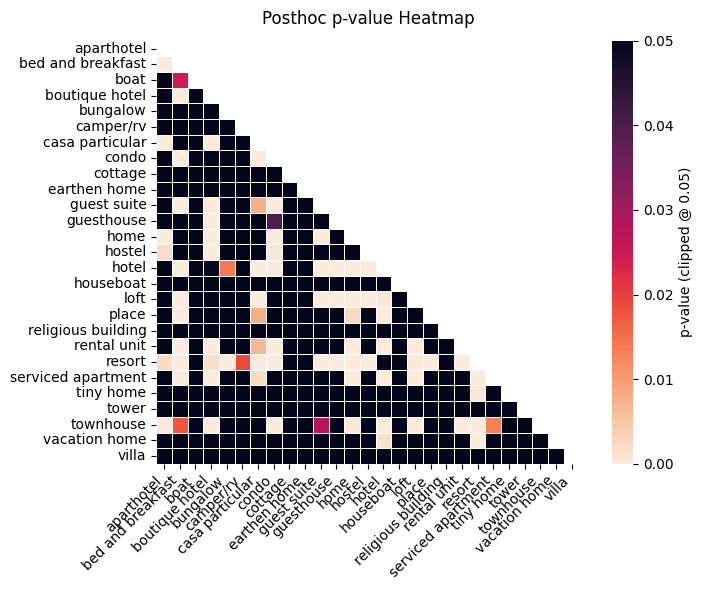


[Groups outlier statistics (factor=1.5)]
| room_structure_type   |   outlier_count |   outlier_ratio |
|-----------------------|-----------------|-----------------|
| rental unit           |              86 |      0.00576253 |
| condo                 |              31 |      0.0299228  |
| home                  |              63 |      0.021291   |
| guest suite           |               6 |      0.0155039  |
| place                 |               8 |      0.131148   |
| loft                  |              24 |      0.0677966  |
| townhouse             |               4 |      0.00414938 |
| bed and breakfast     |               1 |      0.0166667  |
| serviced apartment    |               1 |      0.00460829 |
| guesthouse            |               2 |      0.0350877  |
| houseboat             |               0 |      0          |
| boutique hotel        |              19 |      0.0896226  |
| boat                  |               0 |      0          |
| villa                 |   

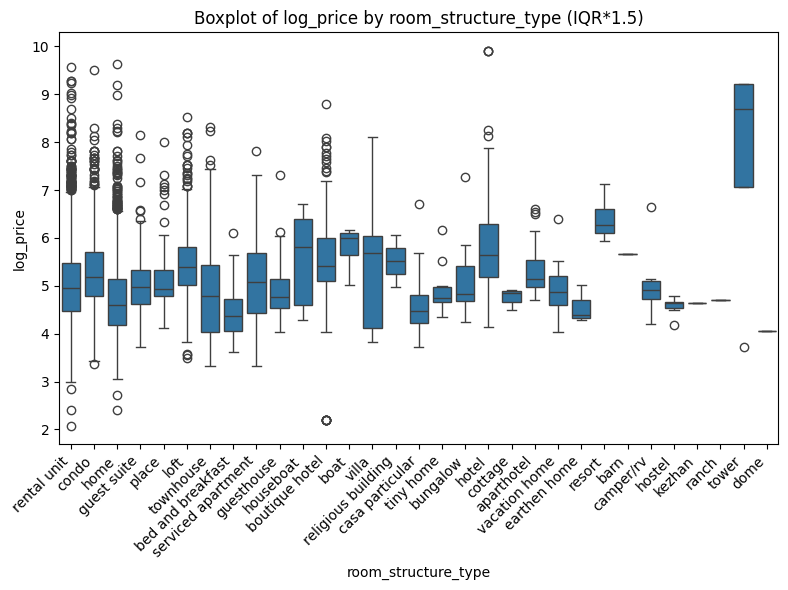


=== 군집화로 도출한 새로운 그룹 카테고리 ===
Group 1: ['aparthotel', 'boat', 'boutique hotel', 'bungalow', 'condo', 'cottage', 'houseboat', 'loft', 'tiny home', 'villa']
Group 2: ['hotel', 'resort', 'tower']
Group 3: ['guest suite', 'guesthouse', 'place', 'rental unit', 'serviced apartment']
Group 4: ['bed and breakfast', 'camper/rv', 'casa particular', 'earthen home', 'home', 'hostel', 'religious building', 'vacation home']
Group 5: ['townhouse']

[Kruskal–Wallis: price ~ room_new_type]
사용 그룹: 4개 (min_n=2)
Kruskal–Wallis H = 1566.8597, p-value = 0.0000

H0: room_new_type 그룹 간 price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 room_new_type 그룹의 price 분포가 다르다.

p-value < 0.05 → 귀무가설 기각. Dunn 사후검정(holm) 진행.

[Dunn 다중비교 (holm)]
+-----------+--------+-----------+--------+-------------+
|           |   High |   Low-Mid |    Mid |   Upper-Mid |
|-----------+--------+-----------+--------+-------------|
| High      | 1.0000 |    0.0000 | 0.0000 |      0.0000 |
| Low-Mid   | 0.0000 |    1.0000 | 0.0000 |      0.0000 |
| Mid  

/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_67686/22791212.py:1133: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=groups, showfliers=True)  # hide internal fliers


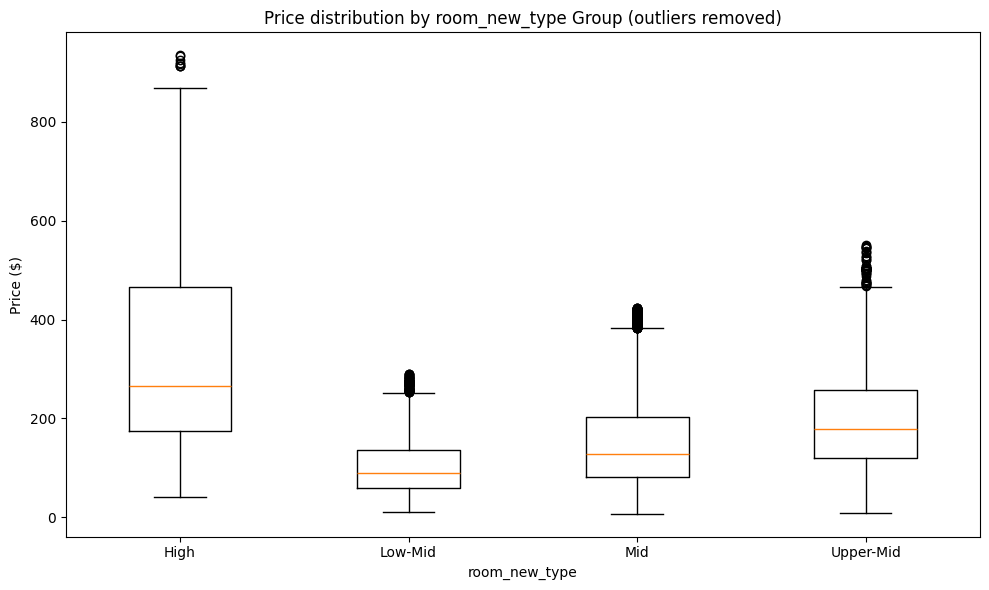

=== room_new_type 별 price 이상치 ===
전체 이상치 개수: 1395.0
전체 이상치 비율: 0.0625
Original rows: 22308, Without outliers: 20913
Saved without 'Unnamed: 0' and without index.


In [57]:
# -------
# library
# -------

# Standard library
from itertools import combinations

# Typing
from typing import Any, Dict, Tuple, Union

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reporting
from tabulate import tabulate

# Statistical analysis
import scipy.stats as stats
from scipy.stats import levene
from scipy.spatial.distance import squareform

# Clustering
import scipy.cluster.hierarchy as sch

# Post-hoc tests
import scikit_posthocs as sp

# Modeling
import statsmodels.api as sm

# Network analysis
import networkx as nx


# -----------
# My function!
# -----------

class normality:
    # 정규성 검정 결과
    def test(
        series: pd.Series,
        alpha: float = 0.05,
        verbose: bool = True
    ) -> Dict[str, Any]:

        """
        주어진 수치형 시리즈에 대해 여러 정규성 검정을 수행하고 결과를 딕셔너리로 반환합니다.

        Args:
            series: pandas Series, numeric 데이터 (NaN은 자동 제거)
            alpha: 유의수준 (p-value 비교 기준)
            verbose: True일 경우 결과 요약을 콘솔에 출력

        Returns:
            Dict[str, Any]:
                {
                    'n': 표본 수,
                    'skew': 왜도 (정규분포에서 0),
                    'kurt_excess': 초과 첨도 (정규분포에서 0),

                    'shapiro_stat': Shapiro-Wilk 통계량,
                    'shapiro_p' : Shapiro-Wilk p-value,
                    'dagostino_k2': D’Agostino K² 통계량,
                    'dagostino_p': D’Agostino K² p-value,
                    'jarque_bera': Jarque–Bera 통계량,
                    'jarque_bera_p': Jarque–Bera p-value,
                    'anderson_stat': Anderson–Darling 통계량,
                    'anderson_crit': {유의수준: 임계값, ...},
                    'lilliefors_stat': Lilliefors KS 통계량,
                    'lilliefors_p': Lilliefors p-value,

                    'practical_normal': 실무적 판정 (skew<0.5 & |kurt|<1)
                }
        """

        # 1. 데이터 전처리
        arr = pd.to_numeric(series, errors='coerce').dropna().values
        n = arr.size

        # 2. 기초 통계량
        skewness = stats.skew(arr, bias=False)
        kurt_excess = stats.kurtosis(arr, fisher=True, bias=False)

        # 3. 정규성 검정
        sh_stat, sh_p = stats.shapiro(arr)
        k2_stat, k2_p = stats.normaltest(arr)
        jb_stat, jb_p = stats.jarque_bera(arr)
        ad_res = stats.anderson(arr, dist='norm')
        ks_stat, ks_p = sm.stats.diagnostic.kstest_normal(arr)

        # 4. 실무적 판정
        practical = (abs(skewness) < 0.5) and (abs(kurt_excess) < 1)

        # 65 결과 집계
        results: Dict[str, Any] = {
            'n': n,
            'skew': skewness,
            'kurt_excess': kurt_excess,
            'shapiro_stat': sh_stat,
            'shapiro_p' : sh_p,
            'dagostino_k2': k2_stat,
            'dagostino_p': k2_p,
            'jarque_bera': jb_stat,
            'jarque_bera_p': jb_p,
            'anderson_stat': ad_res.statistic,
            'anderson_crit': dict(zip(ad_res.significance_level, ad_res.critical_values)),
            'lilliefors_stat': ks_stat,
            'lilliefors_p': ks_p,
            'practical_normal': practical
        }

        if verbose:
            normality.print_normality(results, ad_res)

        # return results


    # 정규성 검정 결과 표 형식으로 정리
    def print_normality(
        results: Dict[str, Any],
        ad_res: Any,
        alpha: float = 0.05
    ) -> None:

        """
        정규성 검정 결과를 표 형식으로 출력합니다.

        Args:
            results: assess_normality()가 반환한 결과 딕셔너리
            ad_res: stats.anderson()의 반환 객체
            alpha: 유의수준 (default=0.05)
        """

        table = []
        # 1. 왜도, 첨도
        table.append([
            "Skew (왜도)",
            f"{results['skew']:.3f}",
            "-",
            "-"
        ])
        table.append([
            "Excess Kurtosis (첨도)",
            f"{results['kurt_excess']:.3f}",
            "-",
            "-"
        ])

        # 2. Shapiro - 표본 개수가 적을 땐, 적합하지 않다.
        table.append([
            "Shapiro-Wilk",
            f"{results['shapiro_stat']:.3f}",
            f"p={results['shapiro_p']:.3f}",
            "Reject" if results['shapiro_p'] < alpha else "Fail"
        ])

        # 3. D'Agostino K² - 표본 개수가 많을 때 적합하다.
        table.append([
            "D’Agostino K²",
            f"{results['dagostino_k2']:.3f}",
            f"p={results['dagostino_p']:.3f}",
            "Reject" if results['dagostino_p'] < alpha else "Fail"
        ])

        # 4. Jarque–Bera
        table.append([
            "Jarque–Bera",
            f"{results['jarque_bera']:.3f}",
            f"p={results['jarque_bera_p']:.3f}",
            "Reject" if results['jarque_bera_p'] < alpha else "Fail"
        ])

        # 5. Lilliefors KS
        table.append([
            "Lilliefors KS",
            f"{results['lilliefors_stat']:.3f}",
            f"p={results['lilliefors_p']:.3f}",
            "Reject" if results['lilliefors_p'] < alpha else "Fail"
        ])

        # 6. Anderson–Darling (여러 유의수준)
        for sl, cv in results['anderson_crit'].items():
            decision = "Reject" if results['anderson_stat'] > cv else "Fail"
            table.append([
                f"Anderson–Darling @{sl}%",
                f"{results['anderson_stat']:.3f}",
                f"crit={cv:.3f}",
                decision
            ])

        # 7. 실무적 판정
        table.append([
            "Practical Normal",
            "-",
            "-",
            str(results['practical_normal'])
        ])

        headers = ["검정항목", "통계량", "p-값 / 임계값", "판정"]
        print(f"\n[정규성 검정 결과]")
        print(tabulate(table, headers=headers, tablefmt="github"))

class stat_test:
    # 가설검정 방식 추천 함수
    def decide(
            df: pd.DataFrame,
            X: str,
            y: str,
            alpha: float = 0.05,
            max_shapiro_n: int = 5000,
            center: str = 'median',
            tablefmt: str = 'github',
            rng_seed: int = 0,
            small: float = 1e-3,
            verbose: bool = True,
    ) -> Dict[str, Any]:
        """
        ANOVA, Welch ANOVA, Kruskal–Wallis 중
        어떤 검정을 사용할지 판정합니다.

        Args:
            df: pandas DataFrame. 분석할 데이터프레임.
            X: str. 독립변수 컬럼명.
            y: str. 종속변수 컬럼명.
            alpha: float. 유의수준(기본 0.05).
            max_shapiro_n: int. Shapiro-Wilk 최대 표본크기.
            center: {'median','mean','trimmed'}. Levene 검정 옵션.
            tablefmt: str. tabulate 출력 포맷.
            rng_seed: int. 재현용 무작위 시드.
            small: float. 이보다 작은 p는 지수 표기.
            verbose: bool. True면 콘솔에 결과 출력.

        Returns:
            Dict[str, Any]:
                {
                    'normal_tbl': DataFrame,     # 그룹별 n, shapiro_p, k2_p
                    'normality_sw': bool,        # Shapiro 전체 그룹 만족 여부
                    'normality_k2': bool,        # D’Agostino K² 전체 그룹 만족 여부
                    'normality': bool,           # 둘 다 만족 시 True
                    'levene_p': float,           # Levene’s test p-value
                    'recommend': str,            # 'anova'|'welch'|'transform_or_nonparam'|'kruskal'
                    'test_name': str,            # 최종 추천 검정 이름
                    'test_stat': float,          # 추천 검정 통계량
                    'test_p': float,             # 추천 검정 p-value
                }
        """
        # 1. NA 제거 & 서브셋
        sub = df[[X, y]].dropna().copy()
        groups = sub[X].unique()
        rng = np.random.default_rng(rng_seed)

        # 2. 그룹별 정규성 검정
        shapiro_ps, k2_ps, ns = [], [], []
        for g in groups:
            vals = sub.loc[sub[X] == g, y]
            vals = pd.to_numeric(vals, errors='coerce').dropna().values
            n = len(vals)
            ns.append(n)

            # Shapiro-Wilk
            if n >= 3:
                if n <= max_shapiro_n:
                    _, p_sw = stats.shapiro(vals)
                else:
                    sample = rng.choice(vals, size=max_shapiro_n, replace=False)
                    _, p_sw = stats.shapiro(sample)
            else:
                p_sw = np.nan
            shapiro_ps.append(p_sw)

            # D'Agostino K²
            if n >= 8:
                _, p_k2 = stats.normaltest(vals, nan_policy='omit')
            else:
                p_k2 = np.nan
            k2_ps.append(p_k2)

        normal_tbl = (
            pd.DataFrame({
                X: groups,
                'n': ns,
                'shapiro_p': shapiro_ps,
                'k2_p': k2_ps,
            })
            .sort_values('n', ascending=False)
            .reset_index(drop=True)
        )

        # 3. 전체 정규성 판정
        sw_ok = normal_tbl['shapiro_p'].dropna().ge(alpha).all()
        k2_ok = normal_tbl['k2_p'].dropna().ge(alpha).all()
        normality = sw_ok and k2_ok

        # 4. Levene’s test
        lev_groups = [
            sub.loc[sub[X] == g, y]
            .pipe(pd.to_numeric, errors='coerce')
            .dropna()
            .values
            for g in groups
        ]
        lev_groups = [arr for arr in lev_groups if len(arr) >= 2]
        if len(lev_groups) >= 2:
            _, levene_p = stats.levene(*lev_groups, center=center)
        else:
            levene_p = np.nan

        # 5. 추천 로직
        if normality and not np.isnan(levene_p) and levene_p >= alpha:
            recommend = 'anova'
        elif normality and not np.isnan(levene_p) and levene_p < alpha:
            recommend = 'welch'
        elif not normality and not np.isnan(levene_p) and levene_p >= alpha:
            recommend = 'transform_or_nonparam'
        else:
            recommend = 'kruskal'

        # 6. 실제 검정 수행 및 결과 저장
        if recommend == 'anova':
            from scipy.stats import f_oneway
            res = f_oneway(*lev_groups)
            test_name = 'ANOVA'
            test_stat, test_p = res.statistic, res.pvalue
        elif recommend == 'welch':
            from statsmodels.stats.oneway import oneway_anova
            res = oneway_anova(sub[y], sub[X], use_var='unequal')
            test_name = 'Welch ANOVA'
            test_stat, test_p = res.statistic, res.pvalue
        else:
            res = stats.kruskal(*lev_groups)
            test_name = 'Kruskal-Wallis'
            test_stat, test_p = res.statistic, res.pvalue

        # 7. verbose 출력
        if verbose:
            def fmt_p(x):
                if pd.isna(x):
                    return 'nan'
                return f"{x:.2e}" if x < small else f"{x:.4f}"

            disp = normal_tbl.copy()
            disp['shapiro_p'] = disp['shapiro_p'].apply(fmt_p)
            disp['k2_p'] = disp['k2_p'].apply(fmt_p)

            print("\n[정규성]")
            print(tabulate(disp, headers='keys', tablefmt=tablefmt, showindex=False))

            print("\n[등분산성]")
            print(f"Levene p-value = {fmt_p(levene_p)}")

            if recommend == 'anova':
                msg = '→ 고전 ANOVA 가능.'
            elif recommend == 'welch':
                msg = '→ Welch ANOVA 권장 (Games-Howell 사후).'
            elif recommend == 'transform_or_nonparam':
                msg = '→ 로그/Box-Cox 변환 후 모수검정 시도 또는 비모수(Kruskal).'
            else:
                msg = '→ Kruskal-Wallis + Dunn(보정) 권장.'
            print(msg)

            # 검정 결과 테이블
            test_table = [[test_name, f"{test_stat:.3f}", fmt_p(test_p)]]
            print("\n[추천 검정 결과]")
            print(tabulate(test_table, headers=['검정', '통계량', 'p-값'], tablefmt=tablefmt))

        return {
            'normal_tbl': normal_tbl,
            'normality_sw': sw_ok,
            'normality_k2': k2_ok,
            'normality': normality,
            'levene_p': levene_p,
            'recommend': recommend,
            'test_name': test_name,
            'test_stat': test_stat,
            'test_p': test_p,
        }

    # Kruskal 검정과 Dunn 사후 검정까지 진행
    def kruskal_dunn(
        df: pd.DataFrame,
        X: str,
        y: str,
        alpha: float = 0.05,
        adjust: str = 'bonf',      # 'bonf','bonferroni','holm','fdr','fdr_bh'
        min_n: int = 2,            # 이 미만인 그룹은 제외
        tablefmt: str = 'psql',
        round_p: int = 4,
        verbose: bool = True,
    ) -> Dict[str, Any]:
        """
        Kruskal–Wallis 검정 후, 유의할 경우 Dunn 사후검정을 수행합니다.

        Args:
            df: pandas DataFrame. 분석할 데이터프레임.
            X: str. 독립 변수 컬럼명.
            y: str. 종속 변수 컬럼명.
            alpha: float. 유의수준 (기본 0.05).
            adjust: str. 다중비교 보정 방식.
                    'bonf','bonferroni','holm','fdr','fdr_bh' 중 선택.
            min_n: int. 표본수가 이보다 작은 그룹은 검정에서 제외.
            tablefmt: str. tabulate 출력 포맷.
            round_p: int. p-value 출력 소수점 자리수.
            verbose: bool. True일 때 콘솔에 중간 결과를 출력.

        Returns:
            Dict[str, Any] with keys:
                'H'             : float   # Kruskal–Wallis H 통계량
                'p_kw'          : float   # Kruskal–Wallis p-value
                'kw_reject'     : bool    # p_kw < alpha 여부
                'h0'            : str     # 귀무가설 서술
                'h1'            : str     # 대립가설 서술
                'groups_used'   : List    # 사용된 그룹명 리스트
                'group_sizes'   : Series  # 원본 그룹별 표본크기
                'pvals_matrix'  : DataFrame or None  # Dunn 사후 p-값 행렬
                'sig_pairs'     : DataFrame or None  # 유의한 그룹쌍
                'nonsig_pairs'  : DataFrame or None  # 비유의 그룹쌍
        """
        # 1. 결측 제거
        sub = df[[X, y]].dropna().copy()

        # 2. 그룹별 표본크기 확인 및 필터링
        grp_sizes = sub.groupby(X)[y].size()
        groups_used = grp_sizes[grp_sizes >= min_n].index.tolist()
        if verbose:
            dropped = grp_sizes[grp_sizes < min_n]
            print(f"\n[Kruskal–Wallis: {y} ~ {X}]")
            print(f"사용 그룹: {len(groups_used)}개 (min_n={min_n})")
            if not dropped.empty:
                print(f"제외된 소표본 그룹({len(dropped)}): {', '.join(map(str, dropped.index))}")

        # 3. 가설 설정 및 그룹 데이터 준비
        h0 = f"\nH0: {X} 그룹 간 {y} 분포(중앙위치)에 차이가 없다."
        h1 = f"H1: 적어도 한 {X} 그룹의 {y} 분포가 다르다."
        group_arrays = [ sub.loc[sub[X] == g, y].values
                         for g in groups_used ]

        # 그룹이 2개 미만이면 수행 불가
        if len(group_arrays) < 2:
            if verbose:
                print("그룹 수 < 2 → Kruskal–Wallis 수행 불가.")
            return {
                'H': np.nan, 'p_kw': np.nan, 'kw_reject': None,
                'h0': h0, 'h1': h1,
                'groups_used': groups_used,
                'group_sizes': grp_sizes,
                'pvals_matrix': None,
                'sig_pairs': None,
                'nonsig_pairs': None,
            }

        # 4. Kruskal–Wallis 검정
        H, p_kw = stats.kruskal(*group_arrays)
        kw_reject = (p_kw < alpha)
        if verbose:
            print(f"Kruskal–Wallis H = {H:.4f}, p-value = {p_kw:.{round_p}f}")
            print(h0)
            print(h1)
            if not kw_reject:
                print(f"\np-value ≥ {alpha} → 귀무가설 채택. 사후검정 생략.")
                return {
                    'H': H, 'p_kw': p_kw, 'kw_reject': kw_reject,
                    'h0': h0, 'h1': h1,
                    'groups_used': groups_used,
                    'group_sizes': grp_sizes,
                    'pvals_matrix': None,
                    'sig_pairs': None,
                    'nonsig_pairs': None,
                }

        # 5. Dunn 사후검정: 보정 방식 매핑
        adj_map = {
            'bonf': 'bonferroni', 'bonferroni': 'bonferroni',
            'holm': 'holm', 'fdr': 'fdr_bh', 'fdr_bh': 'fdr_bh',
        }
        p_adjust = adj_map.get(adjust.lower(), adjust)
        if verbose:
            print(f"\np-value < {alpha} → 귀무가설 기각. Dunn 사후검정({p_adjust}) 진행.\n")
            print(f"[Dunn 다중비교 ({p_adjust})]")

        pvals = sp.posthoc_dunn(
            sub,
            val_col=y,
            group_col=X,
            p_adjust=p_adjust
        )
        pvals = pvals.reindex(index=groups_used, columns=groups_used)
        if verbose:
            print(tabulate(
                pvals.round(round_p),
                headers='keys', tablefmt=tablefmt,
                showindex=True,
                floatfmt=f".{round_p}f"
            ))

        # 6. 유의/비유의 쌍 분리
        sig, nonsig = [], []
        for g1, g2 in combinations(groups_used, 2):
            p_val = pvals.loc[g1, g2]
            (sig if p_val < alpha else nonsig).append((g1, g2, p_val))

        sig_df = pd.DataFrame(sig, columns=['Group1', 'Group2', 'p-value'])
        nonsig_df = pd.DataFrame(nonsig, columns=['Group1', 'Group2', 'p-value'])
        if verbose:
            print(f"\n=== 유의한 그룹 쌍 (p < {alpha}) ===")
            print(sig_df.empty and "(없음)" or
                  tabulate(sig_df.round(round_p),
                           headers='keys', tablefmt=tablefmt,
                           showindex=False, floatfmt=f".{round_p}f"))
            print(f"\n=== 유의하지 않은 그룹 쌍 (p ≥ {alpha}) ===")
            print(nonsig_df.empty and "(없음)" or
                  tabulate(nonsig_df.round(round_p),
                           headers='keys', tablefmt=tablefmt,
                           showindex=False, floatfmt=f".{round_p}f"))

        # 7. 결과 반환
        return {
            'H': H,
            'p_kw': p_kw,
            'kw_reject': kw_reject,
            'h0': h0,
            'h1': h1,
            'groups_used': groups_used,
            'group_sizes': grp_sizes,
            'pvals_matrix': pvals,
            'sig_pairs': sig_df,
            'nonsig_pairs': nonsig_df,
        }

    # 카이제곱 독립성 검정
    def chi2_assoc(
        df: pd.DataFrame,
        X: str,
        Y: str,
        alpha: float = 0.05,
        dropna: bool = True,
        tablefmt: str = 'psql',
        verbose: bool = True,
    ) -> Dict[str, Any]:
        """
        두 범주형 변수(X, Y)의 독립성 검정(Chi-square) 수행,
        효과크기(Cramér’s V) 계산 및 기대도수 진단을 한 번에 처리합니다.

        Args:
            df: pandas DataFrame. 분석할 데이터프레임.
            X: str. 첫 번째 범주형 변수 컬럼명.
            Y: str. 두 번째 범주형 변수 컬럼명.
            alpha: float. 유의수준(기본 0.05).
            dropna: bool. True면 결측 행 제거, False면 "Unknown"으로 대체.
            tablefmt: str. tabulate 출력 포맷.
            verbose: bool. True일 때 콘솔에 중간 결과를 출력.

        Returns:
            Dict[str, Any] with keys:
                'chi2'               : float     # chi2 통계량
                'p'                  : float     # p-value
                'dof'                : int       # 자유도
                'n'                  : int       # 전체 표본 수
                'cramers_v'          : float     # 효과크기 (Cramér’s V)
                'expected_frac_lt5'  : float     # 기대도수 < 5 셀 비율
                'decision'           : str       # 검정 결과 요약 메시지
                'crosstab'           : DataFrame # 관측 교차표
                'expected'           : DataFrame # 기대도수 교차표
                'resid_std'          : DataFrame # 표준화 잔차
        """
        # 1. 데이터 준비
        sub = df[[X, Y]].copy()
        if dropna:
            sub = sub.dropna()
        else:
            sub = sub.fillna("Unknown")

        # 2. 관측 교차표 생성
        ct = pd.crosstab(sub[X], sub[Y])

        # 3. Chi-square 독립성 검정
        chi2, p, dof, expected = stats.chi2_contingency(ct, correction=False)
        expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)

        # 4. 효과크기 (Cramér’s V)
        n = int(sub.shape[0])
        r, c = ct.shape
        cramers_v = np.sqrt(chi2 / (n * (min(r, c) - 1))) if min(r, c) > 1 else np.nan

        # 5. 기대도수 < 5 셀 비율
        expected_frac_lt5 = (expected < 5).sum().sum() / expected.size

        # 6. 표준화 잔차 계산
        resid_std = (ct - expected_df) / np.sqrt(expected_df)

        # 7. 결론 메시지
        if p < alpha:
            decision = (
                f"p={p:.3g} < {alpha} → 귀무가설 기각: {X}와 {Y}는 통계적으로 연관 있음."
            )
        else:
            decision = (
                f"p={p:.3g} ≥ {alpha} → 귀무가설 채택: 독립성을 기각할 증거 부족."
            )

        # 8. verbose 출력
        if verbose:
            print("=== Chi-square 독립성 검정 결과 ===")
            print(f"chi2 = {chi2:.4f}, dof = {dof}, n = {n}, p = {p:.3g}")
            print(f"Cramér’s V = {cramers_v:.4f}")
            print(f"기대도수 < 5 셀 비율 = {expected_frac_lt5:.2%}")
            print(decision)
            print("\n--- 관측 교차표 ---")
            print(tabulate(ct, headers='keys', tablefmt=tablefmt, showindex=True))
            print("\n--- 기대도수 ---")
            print(tabulate(expected_df.round(2), headers='keys', tablefmt=tablefmt, showindex=True))
            print("\n--- 표준화 잔차 ---")
            print(tabulate(resid_std.round(2), headers='keys', tablefmt=tablefmt, showindex=True))

        # 9. 결과 반환
        return {
            'chi2': chi2,
            'p': p,
            'dof': dof,
            'n': n,
            'cramers_v': cramers_v,
            'expected_frac_lt5': expected_frac_lt5,
            'decision': decision,
            'crosstab': ct,
            'expected': expected_df,
            'resid_std': resid_std,
        }

    def p_heatmap(
            pmat: pd.DataFrame,
            alpha: float = 0.05,
            clip_upper: float | None = 0.05,  # 색상 범위를 0~clip_upper로 제한 (기본=0.05)
            annot_mode: str = "stars",  # "stars" | "p" | "logp" | "none"
            lower_triangle_only: bool = True,
            cmap: str | None = None,  # 예: "rocket_r", "mako", "viridis_r"
            figsize: tuple | None = None,
            star_levels: tuple = (0.001, 0.01, 0.05),  # (***) (**) (*) cutoffs
            text_color: str = "black",
            font_size: int = 8,
            cbar: bool = True,
    ):
        """
        예쁜 Seaborn 히트맵으로 posthoc p-value 시각화.

        Parameters
        ----------
        pmat : DataFrame
            대칭 p-value 행렬.
        alpha : float
            유의수준 (색상 해석/legend 참고용).
        clip_upper : float or None
            색 스케일 상한. None이면 pmat max 사용.
            상한을 alpha(또는 0.05) 근처로 두면 유의/비유의 대비가 잘 보임.
        annot_mode : {"stars","p","logp","none"}
            셀 텍스트 표시 방식.
        lower_triangle_only : bool
            True면 상삼각 마스크 → 중복 제거.
        cmap : str or None
            팔레트. None이면 'rocket_r' 사용 (작은 p 진한 핑크/보라 계열).
        figsize : tuple or None
            자동 크기 선택.
        star_levels : tuple
            (p<0.001, p<0.01, p<0.05) 같은 cutoffs. annot_mode="stars"에서 사용.
        text_color : str
            주석 텍스트 색.
        font_size : int
            주석 폰트 크기.
        cbar : bool
            컬러바 표시 여부.

        Returns
        -------
        fig, ax
        """
        P = pmat.astype(float).copy()

        # 대각선 비교 없음
        np.fill_diagonal(P.values, np.nan)

        # 마스크
        mask = None
        if lower_triangle_only:
            mask = np.triu(np.ones_like(P, dtype=bool), k=0)  # diag 포함 상삼각 가리기

        # 색상 스케일 데이터
        plot_vals = P.copy()
        if clip_upper is not None:
            plot_vals = plot_vals.clip(upper=clip_upper)

        # 팔레트
        if cmap is None:
            cmap = "rocket_r"  # 작은 p가 진하게

        # Figure 크기 자동
        if figsize is None:
            n = P.shape[0]
            figsize = (max(5, n * 0.55), max(4, n * 0.55))

        # annot 데이터 생성
        if annot_mode == "none":
            annot = False
        else:
            annot_arr = np.empty_like(P, dtype=object)
            annot_arr[:] = ""
            for i in range(P.shape[0]):
                for j in range(P.shape[1]):
                    if lower_triangle_only and j >= i:
                        continue
                    p = P.iat[i, j]
                    if np.isnan(p):
                        continue

                    if annot_mode == "p":
                        # 3자리 반올림, 아주 작으면 <0.001 표시
                        annot_arr[i, j] = "<0.001" if p < 0.001 else f"{p:.3f}"

                    elif annot_mode == "logp":
                        annot_arr[i, j] = f"{-np.log10(max(p, 1e-300)):.2f}"

                    elif annot_mode == "stars":
                        # 별표 등급
                        if p < star_levels[0]:
                            annot_arr[i, j] = "***"
                        elif p < star_levels[1]:
                            annot_arr[i, j] = "**"
                        elif p < star_levels[2]:
                            annot_arr[i, j] = "*"
                        else:
                            annot_arr[i, j] = "ns"

                    else:
                        annot_arr[i, j] = ""

            annot = annot_arr
        # ---- plot ----
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(
            plot_vals,
            mask=mask,
            cmap=cmap,
            annot=annot,
            fmt="",
            annot_kws={"color": text_color, "fontsize": font_size},
            cbar=cbar,
            vmin=0,
            vmax=clip_upper if clip_upper is not None else None,
            cbar_kws={'label': f"p-value (clipped @ {clip_upper})" if clip_upper else "p-value"},
            linewidths=0.5,
            linecolor='White',
            square=True,
            ax=ax
        )

        ax.set_title("Posthoc p-value Heatmap", pad=12)
        plt.xticks(rotation=45, ha='right')
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.tight_layout()
        return fig, ax

class outlier:
    def robust_bounds(df, group_col, val_col, k=3):
        out = []
        for g, s in df.groupby(group_col)[val_col]:
            vals = s.dropna()
            med = vals.median()
            mad = (np.abs(vals - med)).median()
            madn = 1.4826 * mad  # 정규 보정
            lower = med - k * madn
            upper = med + k * madn
            out.append((g, med, lower, upper, len(vals)))
        return pd.DataFrame(out, columns=[group_col, 'median', 'lower', 'upper', 'n'])

    def compute_iqr_bounds(
            series: pd.Series,
            factor: float = 1.5
    ) -> Tuple[float, float]:
        """
        IQR 기반 이상치 경계(lower, upper)를 계산합니다.

        Args:
            series: pd.Series. 숫자형 데이터.
            factor: float. IQR에 곱할 계수 (기본 1.5).

        Returns:
            Tuple[float, float]: (lower_bound, upper_bound)
        """
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        return q1 - factor * iqr, q3 + factor * iqr

    def stats(
            series: pd.Series,
            factor: float = 1.5
    ) -> pd.Series:
        """
        주어진 시리즈에서 IQR 기준 이상치의 개수와 비율을 계산합니다.

        Args:
            series: pd.Series. 숫자형 데이터.
            factor: float. IQR에 곱할 계수 (기본 1.5).

        Returns:
            pd.Series with index ['outlier_count','outlier_ratio']:
              outlier_count: 이상치 개수 (int)
              outlier_ratio: 이상치 비율 (float)
        """
        lower, upper = outlier.compute_iqr_bounds(series, factor)
        mask = (series < lower) | (series > upper)
        return pd.Series({
            'outlier_count': int(mask.sum()),
            'outlier_ratio': float(mask.mean())
        })

    def describe_without(
            series: pd.Series,
            factor: float = 1.5
    ) -> pd.Series:
        """
        IQR 기준 이상치를 제거한 후 남은 값들의 기술 통계(describe)를 반환합니다.

        Args:
            series: pd.Series. 숫자형 데이터.
            factor: float. IQR에 곱할 계수 (기본 1.5).

        Returns:
            pd.Series: filtered.describe()
        """
        lower, upper = outlier.compute_iqr_bounds(series, factor)
        filtered = series[(series >= lower) & (series <= upper)]
        return filtered.describe()

    def is_not(
            series: pd.Series,
            factor: float = 1.5
    ) -> pd.Series:
        """
        IQR 기준으로 이상치가 아닌 값에 대해 True를, 이상치에 대해 False를 반환하는 Boolean 마스크.

        Args:
            series: pd.Series. 숫자형 데이터.
            factor: float. IQR에 곱할 계수 (기본 1.5).

        Returns:
            pd.Series of bool: 동일한 인덱스, True=정상치, False=이상치
        """
        lower, upper = outlier.compute_iqr_bounds(series, factor)
        return (series >= lower) & (series <= upper)

    def boxplot(
            df: pd.DataFrame,
            X: str,
            y: str,
            factor: float = 1.5,
            figsize: tuple = (10, 6),
            tablefmt: str = 'github',
            verbose: bool = True
    ) -> None:
        """
        1.5 IQR 기준으로 이상치 경계를 계산하고,
        그룹별 이상치 통계와 함께 박스플롯을 그립니다.

        Args:
            df: pandas DataFrame.
            group_col: str. 그룹 구분 컬럼명.
            value_col: str. 수치형 컬럼명.
            factor: float. IQR에 곱할 계수 (기본 1.5).
            figsize: tuple. 그래프 크기 (width, height).
            tablefmt: str. tabulate 출력 포맷.
            verbose: bool. True면 그룹별 이상치 통계 출력.

        Returns:
            None. 플롯과 통계 테이블을 출력합니다.
        """
        # 1. 그룹별 이상치 통계 수집
        stats_list = []
        for g in df[X].dropna().unique():
            series = pd.to_numeric(df.loc[df[X] == g, y], errors='coerce')
            # compute outlier stats
            st = outlier.stats(series, factor)
            stats_list.append({X: g, **st.to_dict()})
        stats_df = pd.DataFrame(stats_list)

        # 2. 이상치 통계 출력
        if verbose:
            print(f"\n[Groups outlier statistics (factor={factor})]")
            print(tabulate(stats_df, headers='keys', tablefmt=tablefmt, showindex=False))

        # 3. 박스플롯 그리기
        plt.figure(figsize=figsize)
        sns.boxplot(
            x=X,
            y=y,
            data=df,
            whis=factor,
            showfliers=True
        )
        plt.title(f"Boxplot of {y} by {X} (IQR*{factor})")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


# -------
# library
# -------

# Standard library
from itertools import combinations

# Typing
from typing import Any, Dict, Tuple, Union

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Reporting
from tabulate import tabulate

# Statistical analysis
import scipy.stats as stats
from scipy.stats import levene
from scipy.spatial.distance import squareform

# Clustering
import scipy.cluster.hierarchy as sch

# Post-hoc tests
import scikit_posthocs as sp

# Modeling
import statsmodels.api as sm

# Network analysis
import networkx as nx

# ------------------------------
# 전처리를 완료한 csv 파일 불러오기
# ------------------------------
df = pd.read_csv('/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/1.preprocessing/entire_df.csv', index_col=0)
'''

# ------------------------------
# price 컬럼 정규성 및 분포 확인하기
# ------------------------------
# 1. price 컬럼 정규성 검정 결과 / QQ plot 시각화
print('=== price 정규성 검정 ===')
price_normality = normality.test(df['price']);

plt.figure(figsize=(8, 6))
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title("Price QQ-Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.show()
'''

# 2. price가 이상치로 인해 정규성을 따르지 않기 때문에, log_price 컬럼 추가
df['log_price'] = np.log1p(df['price'])
'''

print('=== log price 정규성 검정 ===')
log_price_normality = normality.test(df['log_price']);

plt.figure(figsize=(8, 6))
stats.probplot(df['log_price'], dist="norm", plot=plt)
plt.title("Log Price QQ-Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.show()

print('\n[이상치 제거 전 price describe]')
print(df['price'].describe())

# -> log_price도 정규성을 띄진 않지만, 왜도 0.57, 첨도 1.04로 정규성을 띄고 있다고 가정
# -> log_price를 기준으로 이상치 제거 기준을 가설 검정을 통해 찾고, 이상치를 제거

# ------------------------------
# 이상치를 정의할 기준 컬럼 찾기
# 1) room_type과 price의 연관성
# ------------------------------
X1 = 'room_type'
y = 'log_price'
alpha = 0.05
max_shapiro_n = 5000

print('\n=== room type 과 price 연관성 가설 검정 ===')
# 1. 정규성과 등분산성 검정 후, Kruskal-Wallis 검정 진행
X1_stat_test = stat_test.decide(df, X1, y, alpha=alpha, verbose=True);

# 2. Kruskal-Wallis 검정 진행, 사후 검정은 Dunn(holm 보정)
X1_res = stat_test.kruskal_dunn(df, X1, y, alpha=alpha, adjust='holm', verbose=True);

# 3. 검정결과 시각화
if X1_res['pvals_matrix'] is not None:
    stat_test.p_heatmap(
        X1_res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="p",
        cmap="rocket_r",
        figsize=(8, 6),
        text_color="black",
    )
    plt.show()

# 4. room type으로 이상치 시각화
outlier.boxplot(df, X1, y, factor=1.5, figsize=(8,6), tablefmt='github', verbose=True)

# -> 적어도 한 개 이상의 room type 쌍의 price 분포가 통계적으로 다르다.
# -> 따라서 room type 을 사용하여 price 이상치를 판단할 수는 있지만,
# -> 박스플롯 확인 결과 room type 은 price 이상치를 완전하게 설명하지 못한다.
'''
# ------------------------------
# 이상치를 정의할 기준 컬럼 찾기
# 2) room_structure_type price의 연관성
# ------------------------------
X2 = 'room_structure_type'
y = 'log_price'
alpha = 0.05
max_shapiro_n = 5000

print('\n=== room structure type 과 price 연관성 가설 검정 ===')
# 1. 정규성과 등분산성 검정 후, Kruskal-Wallis 검정 진행
X2_stat_test = stat_test.decide(df, X2, y, alpha=alpha, verbose=True);

# 2. Kruskal-Wallis 검정 진행, 사후 검정은 Dunn(holm 보정)
X2_res = stat_test.kruskal_dunn(df, X2, y, alpha=alpha, adjust='holm', verbose=True);

# 3. 검정결과 시각화
if X2_res['pvals_matrix'] is not None:
    stat_test.p_heatmap(
        X2_res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="none",
        cmap="rocket_r",
        figsize=(8, 6),
        text_color="black",
    )
    plt.show()

# 4. room structure type 으로 이상치 시각화
outlier.boxplot(df, X2, y, factor=1.5, figsize=(8,6), tablefmt='github', verbose=True);

# -> 적어도 한 개 이상의 room structure type 쌍의 price 분포가 통계적으로 다르다.
# -> 따라서 room structure type 을 사용하여 price 이상치를 판단할 수는 있지만,
# -> 박스플롯 확인 결과 room structure type 은 price 이상치를 완전하게 설명하지 못한다.

# ------------------------------------------------------------------------------------------
# 이상치를 정의할 기준 컬럼 찾기
# 3) room_structure_type 그룹 간 p-value 검사 결과를 바탕으로 새로운 카테고리 제안 (p-value 거리로 군집화)
# ------------------------------------------------------------------------------------------
pmat = X2_res['pvals_matrix']          # Dunn 사후 p-value DataFrame
index = pmat.index

# 1. p 값을 [ε, 1] 범위로 고정
P = np.clip(pmat.values, 1e-10, 1.0)

# 2. 거리 = -log10(p),  p=1 → 0
D = -np.log10(P)
np.fill_diagonal(D, 0)

# 3. linkage (average·k=5 예시)
Z      = sch.linkage(squareform(D), method='average')
labels = sch.fcluster(Z, t=5, criterion='maxclust')

# 4. 매핑
struct_grp_map = dict(zip(index, labels))
df['room_new_type'] = df['room_structure_type'].map(struct_grp_map)

print("\n=== 군집화로 도출한 새로운 그룹 카테고리 ===")
for k in sorted(set(labels)):
    print(f"Group {k}: {[s for s,l in struct_grp_map.items() if l==k]}")

# 5. 군집별 표본 수 & 로그 가격 통계
grp_stat = (
    df.groupby('room_new_type')['price']
      .agg(n='size', median='median', q1=lambda s: s.quantile(.25), q3=lambda s: s.quantile(.75))
      .sort_values('median')
)

# 6. 중앙값과 2사분위, 3사분위를 고려하여 재배치
# - 5번그룹(townhouse)은 금액 특성상 4번그룹에 통합 가능
# - barn, kezhan, ranch, dome은 개수가 부족해 군집화가 불가능 -> 적합한 가격군에 배치
df.loc[df.room_structure_type == 'townhouse', 'room_new_type'] = 3
df.loc[df.room_structure_type == 'barn', 'room_new_type'] = 1
df.loc[df.room_structure_type == 'kezhan', 'room_new_type'] = 4
df.loc[df.room_structure_type == 'ranch', 'room_new_type'] = 4
df.loc[df.room_structure_type == 'dome', 'room_new_type'] = 4

# 7. 그룹명 변경
# - 금액대 유사한 그룹끼리 배치했기에, high, upper mid, mid, low mid로 변경
df['room_new_type'] = df['room_new_type'].astype(int)

group_name_map = {4: "Low-Mid", 3: "Mid", 1: "Upper-Mid",  2: "High"}
df['room_new_type'] = df['room_new_type'].map(group_name_map)

# 8. room new type 과 price 연관성 - kruskal wallis 검정
new_res = stat_test.kruskal_dunn(df, X='room_new_type', y='price', alpha=alpha, adjust='holm', verbose=True);

#9. 박스플롯
bounds = outlier.robust_bounds(df, 'room_new_type', 'price', k=3)

df = df.merge(bounds, on='room_new_type', how='left')
df['is_outlier'] = (df['price'] < df['lower']) | (df['price'] > df['upper'])

plot_df = df.copy()

# Separate clean data and outliers
clean_df = plot_df[~plot_df['is_outlier']]
out_df   = plot_df[plot_df['is_outlier']]

fig, ax = plt.subplots(figsize=(10, 6))

# Box‑and‑whisker for each structure_group (clean data only)
groups = sorted(clean_df['room_new_type'].unique())
data   = [clean_df.loc[clean_df['room_new_type'] == g, 'price'] for g in groups]

ax.boxplot(data, labels=groups, showfliers=True)  # hide internal fliers

ax.set_xlabel("room_new_type")
ax.set_ylabel("Price ($)")
ax.set_title("Price distribution by room_new_type Group (outliers removed)")

plt.tight_layout()
plt.show()

# -> kruskal 검정 결과, 유의하지 않은 그룹쌍은 없었다.
# -> 이후, 박스플롯으로 이상치를 확인해보면 해당 그룹은 이상치를 잘 설명하고 있음을 알 수 있다.

stats_type = df.groupby("room_new_type")['price'].apply(outlier.stats)
print("=== room_new_type 별 price 이상치 ===")

# 인덱스를 컬럼으로 올리기
stats_type = stats_type.reset_index()

# apply 결과를 MultiIndex → DataFrame 으로 펼치기
stats_type = (
    df.groupby("room_new_type")['price']
      .apply(outlier.stats)
      .unstack()              # outlier_count, outlier_ratio 가 각각 컬럼이 됨
      .reset_index()          # 구조를 DataFrame으로 완성
)
type_outlier_count = stats_type['outlier_count'].sum()
type_outlier_ratio = stats_type['outlier_count'].sum() / 22308

print(f"전체 이상치 개수: {type_outlier_count}")
print(f"전체 이상치 비율: {type_outlier_ratio:.4f}")

df.groupby('room_new_type')['price'].describe()
stats_clean = (
    df.groupby('room_new_type')['price']
      .apply(outlier.describe_without)   # → 다중 인덱스 Series
      .unstack()                    # → 행: structure_group, 열: describe 항목
)

mask = df.groupby('room_new_type')['price'] \
         .transform(lambda s: outlier.is_not(s, factor=1.5))

# 2) 이상치가 아닌 행만 골라 새로운 DataFrame에 저장
outlier_removed_df = df[mask].copy()

# 3) 확인 (원본 vs 제거 후 행 개수)
print(f"Original rows: {len(df)}, Without outliers: {len(outlier_removed_df)}")

# 4) 필요하다면 인덱스 리셋
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df = df.loc[~df['is_outlier']].reset_index(drop=True)

df = df.drop(columns=['median', 'lower', 'upper', 'n', 'is_outlier'])
df['room_new_type'] = df['room_new_type'].str.lower()

# 3) 인덱스를 0,1,2… 로 재설정하고 파일에 저장
df = df.reset_index(drop=True)
df.index.name = ''
df.to_csv(
    'entire_remove_outlier.csv',
    index=False,
    header=True,
    encoding='utf-8'
)
print("Saved without 'Unnamed: 0' and without index.")

In [60]:
df['id']

KeyError: 'id'

In [65]:
sample_df = df.head(10)

In [68]:
features = [  # 앞서 선정한 피처 리스트
 'log_price',
 'instant_bookable',
 'availability_90',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'last_review',]

In [69]:
import time
import json
import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.ensemble     import RandomForestRegressor
from sklearn.metrics      import mean_squared_error, r2_score
from requests.adapters    import HTTPAdapter
from urllib3.util.retry   import Retry

# ─────────────────────────────────────────────────────────────────────────────
# 1) Overpass API용 세션 + Retry 설정
#    (ChunkedEncodingError, 5xx, 429 등 재시도)
session = requests.Session()
retry = Retry(
    total=5,
    backoff_factor=0.3,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET", "POST"]
)
adapter = HTTPAdapter(max_retries=retry)
session.mount("http://", adapter)
session.mount("https://", adapter)

OVERPASS_URL  = "http://overpass-api.de/api/interpreter"
OVERPASS_TAGS = [
    ('bus_stop',       ('amenity', 'bus_station')),
    ('subway_station', ('railway', 'station')),
    ('parking',        ('amenity', 'parking')),
    ('park',           ('leisure', 'park')),
    ('supermarket',    ('shop', 'supermarket')),
]

def get_overpass_poi_counts(lat: float, lon: float, radius: int = 1000) -> dict:
    """
    Overpass API 로 반경 내 POI 개수 세기 (stream 모드 + chunk 처리)
    """
    # 1) 태그별 node filter 조합
    filters = "".join(
        f"node[{k}=\"{v}\"](around:{radius},{lat},{lon});\n"
        for _, (k,v) in OVERPASS_TAGS
    )
    query = f"""
    [out:json][timeout:25];
    (
      {filters}
    );
    out body;
    """
    # 2) stream 모드로 안전하게 POST
    resp = session.post(
        OVERPASS_URL,
        data={'data': query},
        timeout=(5, 60),
        stream=True
    )
    resp.raise_for_status()

    # 3) 청크 단위로 읽어서 완전한 JSON 바이트 만들기
    buf = bytearray()
    for chunk in resp.iter_content(chunk_size=1024):
        if chunk:
            buf.extend(chunk)
    data = json.loads(buf.decode('utf-8'))

    # 4) 태그별 카운트 집계
    counts = {name: 0 for name, _ in OVERPASS_TAGS}
    for el in data.get('elements', []):
        tags = el.get('tags', {})
        for name, (k,v) in OVERPASS_TAGS:
            if tags.get(k) == v:
                counts[name] += 1
    return counts

# ─────────────────────────────────────────────────────────────────────────────
# 2) DataFrame에 POI 컬럼 추가 함수
def enrich_poi(df: pd.DataFrame, radius: int = 1000) -> pd.DataFrame:
    """
    df 에 latitude, longitude 컬럼이 있다고 가정.
    각 행마다 get_overpass_poi_counts 호출 → 결과를 새 컬럼으로 붙여서 반환.
    """
    results = []
    for lat, lon in zip(df['latitude'], df['longitude']):
        try:
            counts = get_overpass_poi_counts(lat, lon, radius=radius)
        except Exception as e:
            print(f"[WARN] POI 조회 실패 ({e}), 기본 0으로 대체")
            counts = {name: 0 for name, _ in OVERPASS_TAGS}
        results.append(counts)
        time.sleep(0.1)  # Overpass 과부하 방지
    poi_df = pd.DataFrame(results, index=df.index)
    return pd.concat([df, poi_df], axis=1)

    # --- B) POI 정보로 df 확장 ---
df_enriched = enrich_poi(sample_df, radius=1000)
poi_feats = [name for name, _ in OVERPASS_TAGS]
all_feats = features + poi_feats



['log_price', 'instant_bookable', 'availability_90', 'host_listings_count', 'is_long_term', 'is_activate', 'amenities_cnt', 'accommodates', 'bath_score_mul', 'number_of_reviews', 'review_scores_rating', 'name_length_group', 'description_length_group', 'neighborhood_overview_exists', 'host_about_length_group', 'host_is_superhost', 'host_has_profile_pic', 'host_response_rate_score', 'host_acceptance_rate_score', 'host_location_ny', 'host_location_boolean', 'town_encoded', 'structure_encoded', 'last_review', 'bus_stop', 'subway_station', 'parking', 'park', 'supermarket']


In [71]:
df_enriched

,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,room_type_Private room,room_type_Shared room,structure_encoded,log_price,room_new_type,bus_stop,subway_station,parking,park,supermarket
,,,,,,,,,,,,,,,,,,,,,
0,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,...,True,False,23,5.303305,mid,0,6,2,0,10
1,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,...,True,False,8,4.418841,upper-mid,0,3,0,2,12
2,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,...,False,False,14,4.941642,low-mid,0,7,1,0,12
3,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,...,True,False,23,4.875197,mid,0,10,0,1,14
4,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,...,True,False,23,4.941642,mid,0,15,23,2,10
5,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,NaN,15991,Allen & Irina,2009,"New York, NY",We love to travel. When we travel we like to s...,within an hour,...,False,False,23,4.574711,mid,0,8,0,2,14
6,city scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,16104,Kahshanna,2009,"New York, NY",A former life in fashion and wellness has left...,within an hour,...,True,False,8,4.094345,upper-mid,0,7,0,0,14
7,city scrape,UES Beautiful Blue Room,Beautiful peaceful healthy home,"Location: Five minutes to Central Park, Museum...",16800,Cyn,2009,"New York, NY",Capturing the Steinbeck side of life in its Fi...,within an hour,...,True,False,23,4.219508,mid,0,4,2,2,16
8,city scrape,"Perfect for Your Parents, With Garden & Patio",Parents/grandparents coming to town or are you...,"Residential, village-like atmosphere. Lots of ...",17571,Jane,2009,"New York, NY","I appreciate visitors and know New York well, ...",within an hour,...,True,False,12,5.278115,mid,0,10,0,2,17


In [72]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 3.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [77]:
df_cols100 = df.iloc[:, :100].copy()

In [78]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1) 그룹별 태그 딕셔너리
poi_tags = {
    'transport': {
        'amenity':['bus_station','taxi'],
        'railway':['station']
    },
    'infrastructure': {
        'amenity':['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism':['viewpoint','museum','attraction'],
        'leisure':['park']
    }
}

# 2) 전체 bbox 계산 (약간 패딩 추가)
minx, maxx = df_cols1000.longitude.min()-0.01, df_cols1000.longitude.max()+0.01
miny, maxy = df_cols1000.latitude.min()-0.01, df_cols1000.latitude.max()+0.01

# 3) 한 번에 OSM 데이터 가져오기
gdf = ox.geometries_from_bbox(maxy, miny, maxx, minx, tags={k:v for grp in poi_tags.values() for k,v in grp.items()})

# 4) GeoDataFrame으로 좌표 준비
pts = gpd.GeoDataFrame(df_cols1000, geometry=gpd.points_from_xy(df_cols1000.longitude, df_cols1000.latitude), crs="EPSG:4326")
pts = pts.to_crs(epsg=3857)
pois = gdf.to_crs(epsg=3857).reset_index()

# 5) 공간 인덱스 생성
sindex = pois.sindex

# 6) 그룹별 카운트 함수
def count_group(geom, grp_tags, radius=1000):
    buf = geom.buffer(radius)
    possible = pois.iloc[list(sindex.intersection(buf.bounds))]
    count = 0
    for key, vals in grp_tags.items():
        for val in vals:
            count += possible[(possible[key] == val)].shape[0]
    return count

# 7) 각 그룹별 점수 컬럼 생성
for grp, tags in poi_tags.items():
    df_cols1000[f"{grp}_count"] = [
        count_group(pt, tags, radius=1000) for pt in pts.geometry
    ]



AttributeError: module 'osmnx' has no attribute 'geometries_from_bbox'

In [82]:
df_20 = df.iloc[:, :20].copy()

In [83]:
import time
import json
import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.ensemble     import RandomForestRegressor
from sklearn.metrics      import root_mean_squared_error, r2_score
from requests.adapters    import HTTPAdapter
from urllib3.util.retry   import Retry

# 0) 원본 데이터 로드 (경로·이름은 알맞게)
TARGET = 'estimated_occupancy_l365d'
original_features = [
    'log_price','instant_bookable','availability_90','host_listings_count',
    'is_long_term','is_activate','amenities_cnt','accommodates','bath_score_mul',
    'number_of_reviews','review_scores_rating','name_length_group',
    'description_length_group','neighborhood_overview_exists',
    'host_about_length_group','host_is_superhost','host_has_profile_pic',
    'host_response_rate_score','host_acceptance_rate_score',
    'host_location_ny','host_location_boolean','town_encoded',
    'structure_encoded','last_review'
]

# 1) 그룹별 POI 태그 정의
poi_tags = {
    'transport': {
        'amenity': ['bus_station', 'taxi'],
        'railway': ['station']
    },
    'infrastructure': {
        'amenity': ['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism': ['viewpoint','museum','attraction'],
        'leisure': ['park']
    }
}

# 2) Overpass API 세션 설정
session = requests.Session()
retry_strategy = Retry(
    total=5,
    backoff_factor=0.3,
    status_forcelist=[429,500,502,503,504],
    allowed_methods=["GET","POST"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount("http://", adapter)
session.mount("https://", adapter)
OVERPASS_URL = "http://overpass-api.de/api/interpreter"

# 3) 그룹별 POI 카운트 함수
def get_grouped_poi_counts(lat, lon, radius=1000):
    """
    lat/lon 기준 radius(m) 안에서 poi_tags 그룹별 개수 계산
    """
    # Overpass 쿼리 문자열 생성
    filters = ""
    for grp in poi_tags.values():
        for key, vals in grp.items():
            for v in vals:
                filters += f'node[{key}="{v}"](around:{radius},{lat},{lon});\n'
    query = f"[out:json][timeout:25];({filters});out body;"
    
    # 요청 & 스트림 처리
    resp = session.post(OVERPASS_URL, data={'data': query}, timeout=(5,60), stream=True)
    resp.raise_for_status()
    buf = bytearray()
    for chunk in resp.iter_content(chunk_size=1024):
        if chunk:
            buf.extend(chunk)
    data = json.loads(buf.decode('utf-8'))
    
    # 그룹별 집계
    counts = {grp: 0 for grp in poi_tags}
    for el in data.get("elements", []):
        tags = el.get("tags", {})
        for grp, grp_map in poi_tags.items():
            for key, vals in grp_map.items():
                if tags.get(key) in vals:
                    counts[grp] += 1
    return counts

# 4) 한 번만 호출 → 캐시 저장
def enrich_and_cache(df, radius=1000, cache_path='poi_grouped.csv'):
    rows = []
    for lat, lon in zip(df['latitude'], df['longitude']):
        try:
            rows.append(get_grouped_poi_counts(lat, lon, radius))
        except Exception:
            rows.append({grp:0 for grp in poi_tags})
        time.sleep(0.1)  # 서버 과부하 방지
    poi_df = pd.DataFrame(rows, index=df.index)
    poi_df.to_csv(cache_path)
    return poi_df

# (실제 실행) 캐시 파일이 없으면 생성
import os
CACHE = 'poi_grouped.csv'
if not os.path.exists(CACHE):
    poi_df = enrich_and_cache(df_20, radius=1000, cache_path=CACHE)
else:
    poi_df = df_20.read_csv(CACHE, index_col=0)

# 5) 원본 df와 병합
df_cols1000 = df_20.join(poi_df)
group_feats = list(poi_tags.keys())

# 6) 모델 학습 준비
features = original_features + group_feats
X = df_20[features].fillna(0)
y = df_20[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7) 랜덤포레스트 학습 & 평가
model = RandomForestRegressor(
    n_estimators=200, max_depth=10, min_samples_leaf=3,
    random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R²   :", r2_score(y_test, y_pred))


KeyError: 'latitude'

In [84]:
df_20

,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood
,,,,,,,,,,,,,,,,,,,,
0,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,1.00,0.91,0,Prospect Heights,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights
1,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,1.00,1.00,0,East Harlem,1.0,1.0,"['email', 'phone']",1,1,Neighborhood highlights
2,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,1.00,0.97,1,Harlem,1.0,1.0,"['email', 'phone']",1,1,Neighborhood highlights
3,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,1.00,1.00,1,Williamsburg,2.0,2.0,"['email', 'phone']",1,1,Neighborhood highlights
4,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,1.00,0.91,0,Hell's Kitchen,2.0,2.0,"['email', 'phone']",1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015,"New York, NY",NaN,NaN,1.00,0.91,0,NaN,1.0,2.0,"['email', 'phone']",1,1,NaN
20556,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022,"New York, NY",Are you tired of the tedious and time-consumin...,within an hour,1.00,0.80,1,Bedford-Stuyvesant,24.0,33.0,"['email', 'phone']",1,1,NaN
20557,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015,"Hawthorne, NJ",NaN,within an hour,0.94,0.99,0,Miami Beach,619.0,1974.0,"['email', 'phone', 'work_email']",1,1,NaN
